__Автор__: Карпаев Алексей, ассистент кафедры информатики и вычислительной математики

# Метод конечных элементов: аппроксимация функций. Программная реализация, ОО подход

In [1]:
# стандартные импорты
import numpy as np
import math as m
import matplotlib.pyplot as plt
import timeit
import scipy.linalg

plt.rc('font', size=20)

Определение конечно-элементной сетик и базисных функций-"шапочек":

In [2]:
class FEMMesh:
    
    def __init__(self, xL, xR, numFEs):
        # равноотстоящие узлы
        self.numFEs = numFEs
        self.nodes = list(np.linspace(xL, xR, numFEs + 1))
        self.finiteElems = [ [self.nodes[i], self.nodes[i + 1]] \
                             for i in range(len(self.nodes) - 1)] 
        self.h = float(np.diff(self.nodes)[0])
    
    
    def __str__(self):
        counter = 0
        for elem in self.finiteElems:
            print('Elem #%d: [%.2f, %.2f]' % (counter, elem.xL, elem.xR))
            counter += 1

In [3]:
class BasisFunction:
    
    # индекс "i" базисной функции: 1 <= i <= numNodes - 2
    def __init__(self, mesh, index):
        self.mesh = mesh
        self.i = index # "i" --- параметр
    
    def __call__(self, x):
        xArrayMesh = self.mesh.nodes # для краткости
        i = self.i # для краткости
        
        # функция-"шапка"
        if i != 0 and i != len(xArrayMesh) - 1:
            if x >= xArrayMesh[i - 1] and x < xArrayMesh[i]:
                return (x - xArrayMesh[i - 1]) / self.mesh.h
            elif x >= xArrayMesh[i] and x < xArrayMesh[i + 1]:
                return 1. - (x - xArrayMesh[i]) / self.mesh.h
            else:
                return 0.
            

        # левая функция-"полушапка"
        elif i == 0:
            if x >= xArrayMesh[0] and x < xArrayMesh[1]:
                return 1. - (x - xArrayMesh[i]) / self.mesh.h
            else: 
                return 0.
        
        
        # правая функция-"полушапка"
        elif i == len(xArrayMesh) - 1:
            if x > xArrayMesh[-2] and x <= xArrayMesh[-1]:
                return (x - xArrayMesh[-2]) / self.mesh.h
            else: 
                return 0.
            
    
    def Plot(self):
        xL = self.mesh.nodes[0]
        xR = self.mesh.nodes[-1]
        
        xData = np.linspace(xL, xR, 100)
        yData = np.array([self(x) for x in xData])
        
        plt.figure(figsize=(11, 6))
        plt.plot(xData, yData, '-', lw=2)
        plt.grid(None)
        plt.show()

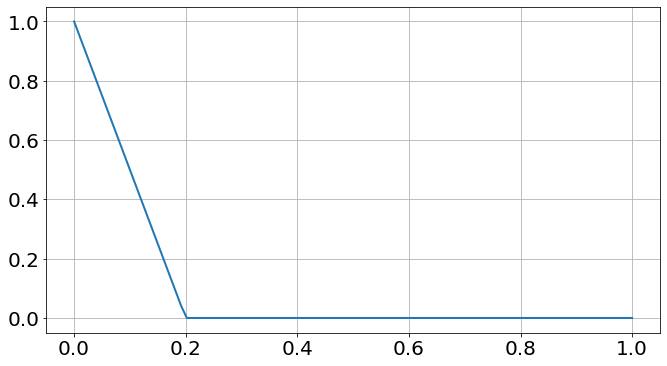

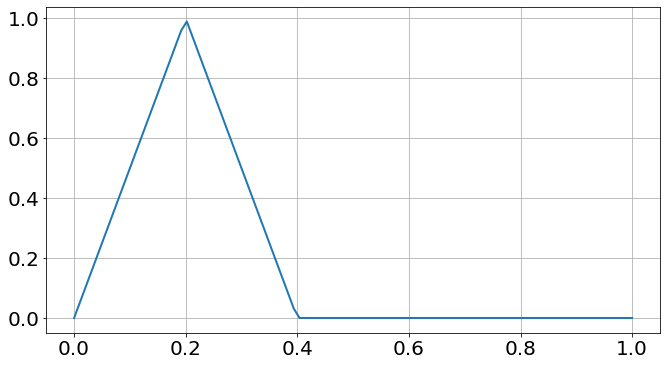

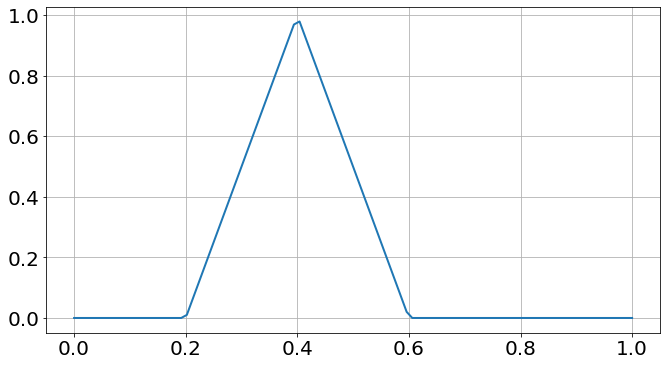

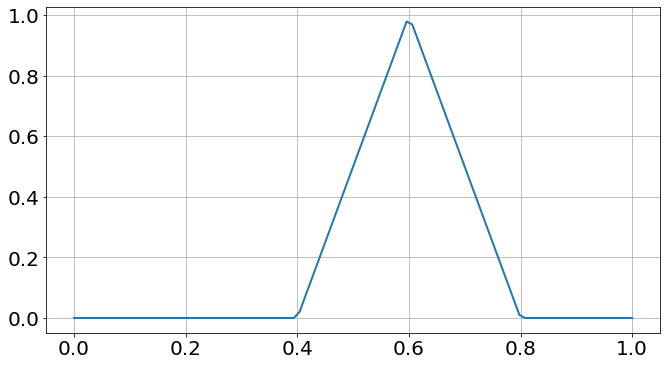

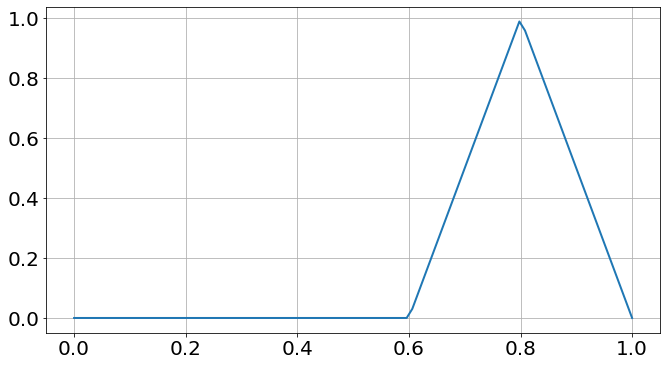

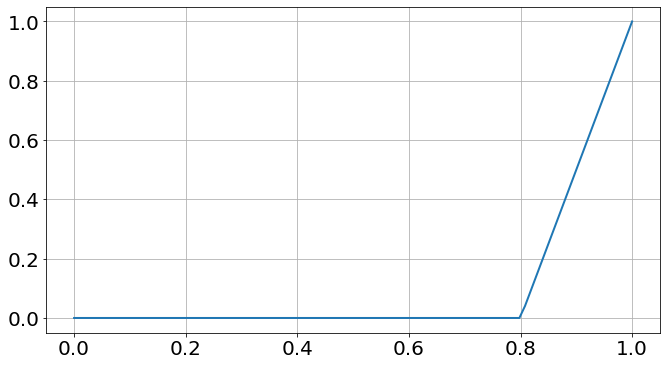

In [4]:
# построение графиков базисных функций
mesh1 = FEMMesh(xL=0., xR=1., numFEs=5)

for i in range(mesh1.numFEs + 1):
    f = BasisFunction(mesh=mesh1, index=i)
    f.Plot()

## Солверы
Создадим класс-солвер для нахождения коэффициентов __методом регрессии__. Данный класс можно использовать в качестве заготовки для создания иерархии классов, в которую будут входить классы-солверы, в которых реализованы методы нахождения коэффициентов:
* наименьших квадратов
* интерполяция
* регрессия.

### Метод регрессии

In [5]:
class FEMSolverRegression:

    def __init__(self, mesh, function, points):
        self.mesh = mesh
        self.f = function
        self.numNodes = len(self.mesh.nodes)
        
        self.BasisFuncs = [BasisFunction(self.mesh, i) \
                            for i in range(0, self.numNodes)]
        
        
        # поля, свойственные методу регрессии
        self.regressionPoints = points
        
        
    def _SetupLinearSystem(self):
        self.M = np.zeros((self.numNodes, self.numNodes))
        self.b = np.zeros(self.numNodes)
        
        for i in range(self.numNodes):
            # вычисление элементов матрицы масс
            for j in range(self.numNodes):
                self.M[i, j] = self._MassMatrixEntry(i, j)
    
            # вычисление элементов вектора нагрузки
            self.b[i] = self._LoadVectorEntry(i)
        
    
    def _MassMatrixEntry(self, i, j):
        points = self.regressionPoints
        value = 0.
        for k in range(len(points)):
            value += self.BasisFuncs[i](points[k])*self.BasisFuncs[j](points[k])
        
        return value
        
    def _LoadVectorEntry(self, i):
        points = self.regressionPoints
        value = 0.
        for k in range(len(points)):
            value += self.BasisFuncs[i](points[k])*self.f(points[k])
        
        return value
        
    
    def Solve(self):
        self._SetupLinearSystem()
        
        # "быстрое" нахождние аналитич. решения СЛАУ;
        # вместо одноименной функции из библиотеки NumPY
        self.alphas = scipy.linalg.solve(self.M, self.b)
    

    def EvaluateSolution(self, x):
        value = 0.
        for alpha, BasisFunc in zip(self.alphas, self.BasisFuncs):
            value += alpha*BasisFunc(x)
        return value
    
    
    def PlotSolution(self):
        xL = self.mesh.nodes[0]
        xR = self.mesh.nodes[-1]
        
        self.xData = np.linspace(xL, xR, 100)
        yData = np.array([self.EvaluateSolution(x) for x in self.xData])
        
        #plt.figure(figsize=(11, 6))
        plt.plot(self.xData, yData, '-', lw=2, label=self.__class__.__name__)
        plt.legend()
        plt.grid(None)
        #plt.show()

In [6]:
# удобней хранить в парах, чтобы не использоввать zip в цикле for
class SolverPair:
    
    def __init__(self, methodClass, points):
        self.methodClass = methodClass
        self.points = points

In [7]:
# использование
testFunc = lambda t: 1. + (t**2)*np.sin(2.*m.pi*t)

xL_, xR_ = 0., 1.
mesh = FEMMesh(xL=xL_, xR=xR_, numFEs=5)
regressionPoints = np.linspace(xL_, xR_, 40)

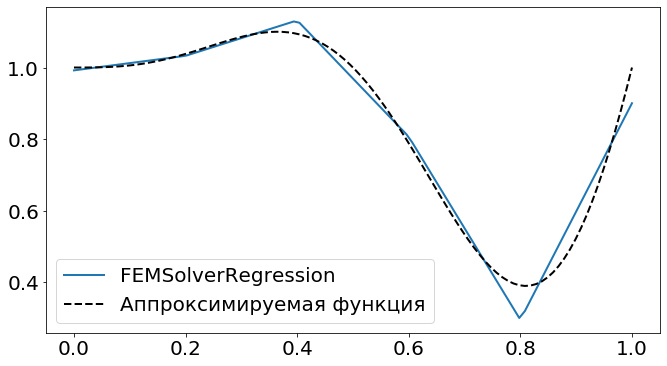

In [8]:
solverRegression = SolverPair(FEMSolverRegression, regressionPoints)

# вместо списка можно использовать словарь (список с доступом по ключу)
solversClass = [solverRegression]

plt.figure(figsize=(11, 6))
for solverClass in solversClass:
    solver = solverClass.methodClass(mesh, testFunc, solverClass.points)
    solver.Solve()
    solver.PlotSolution()

# график аппроксимируемой функции
plt.plot(solver.xData, testFunc(solver.xData), 'k--', label='Аппроксимируемая функция', lw=2)
plt.legend(loc='best')
plt.grid(None)
plt.show()

## Вопросы?

## Дополнительный материал: простейшая задача из дисциплины "Анализ данных"

### Задача регрессии 
Представим, что в результате эусперимента мы $R$ раз приблизительно замерили значение величины $y$, являющейся функцией $y = testFunc(x)$, и нам требуется восстановить истинную зависимость используя измеренные значения. Мы можем сымитировать эксперимент, добавив случайный шум к нашей тестовой функции:

In [9]:
# новые импорты
import numpy.random as rnd
import math as m

In [10]:
class NoisyFunc:
    
    def __init__(self, f, noiseLevel):
        self.f = f
        self.noiseLevel = noiseLevel
        
    
    def __call__(self, x):
        # инициализация генератора псевдослучайных чисел: 
        # требуется для получения одной и той же последовательности случайных чисел
        seed_ = int(m.floor(1e3*x))
        rnd.seed(seed_)
        
        mean = 0.
        noise = rnd.normal(mean, self.noiseLevel)
        #if abs(noise) >= 1.*self.noiseLevel:
        #    noise = 0.
            
        return self.f(x) + noise

In [11]:
# то же самое, что и 2 ячейки вверх, только доп. выводим измеренные в "эксперименте" значения;
# можно поменять значения числах КЭ, точек регрессии и посмотреть, 
# какой вид принимает аппроксимант при различных числах КЭ, точек регрессии.

testFuncs = [lambda t: 1. + np.sin((t + 10.)**2),
            lambda t: 1. + np.sin(2.*m.pi*(t**2)),
            lambda t: 1.]

testFuncs.reverse()


# после эксперимента число точек регрессии R --- фиксировано, 
# уровень шума --- фиксирован;
# мы можем только менять МОДЕЛЬ (число конечных элементов)
R = 30
testFuncsNoisy = [NoisyFunc(f, noiseLevel=10.*0.05) for f in testFuncs]
# "эксперимент" завершен.

# подбираем МОДЕЛЬ (число конечных элементов)
mesh2 = FEMMesh(xL=xL_, xR=xR_, numFEs=int(0.1*R))

regressionPoints2 = np.linspace(xL_, xR_, R)

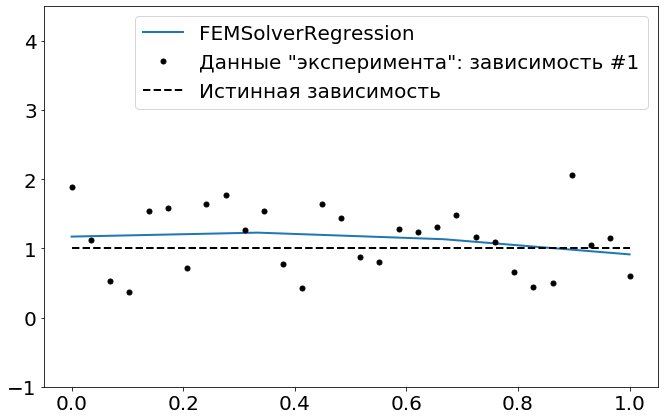

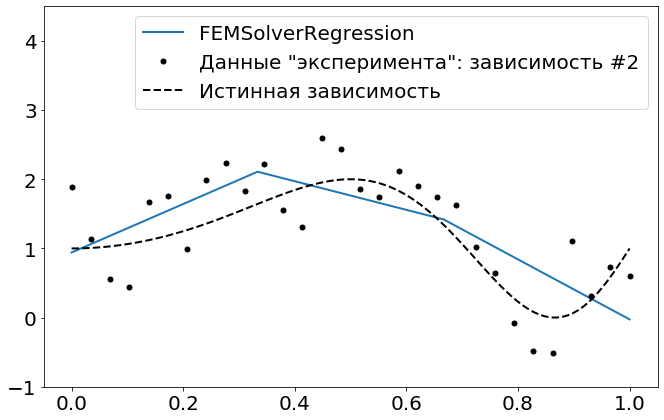

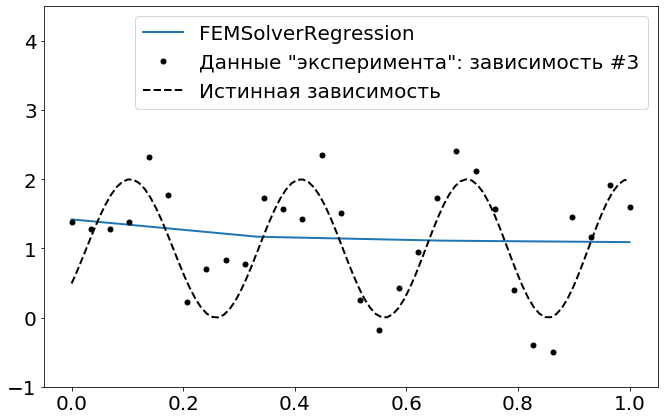

In [12]:
for testFunc_, testFuncNoisy, counter in zip(testFuncs, testFuncsNoisy, \
                                            range(len(testFuncs))):
    solver = FEMSolverRegression(mesh2, testFuncNoisy, regressionPoints2)
    solver.Solve()
    
    plt.figure(figsize=(11, 7))
    solver.PlotSolution()
    
    plt.plot(solver.regressionPoints, [solver.f(x) for x in solver.regressionPoints], 'ko',\
             label='Данные "эксперимента": зависимость #%d' % (counter + 1), lw=2, markersize=5)
    
    plt.plot(solver.xData, [testFunc_(x) for x in solver.xData], 'k--', lw=2, \
             label='Истинная зависимость')

    plt.xlim
    plt.grid(None)
    plt.legend(loc='best')
    plt.ylim([-1., 4.5])

plt.show()